<a href="https://www.kaggle.com/code/ravimandliya/lesson-1-is-it-animated?scriptVersionId=137324672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Animated vs Real

Goal: For a given set of images, identify if it is animated or not. This is a fun project built while taking [Practical Deep Learning](https://course.fast.ai/) course. 

## Setup

In [1]:
# Install fast ai and duckduckgo

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

from typing import List
import itertools

def search_images(search_term: str, max_images: int=30) -> List[str]:
    """
    Get a list of URLs for images
    
    Args:
        search_term (str): Search term for finding images.
        max_images (int): Number of images to be searched
    Return:
        List of urls
    """
    print(f"Searching for '{search_term}'")
    with DDGS() as ddgs:
        ddgs_image_gen = ddgs.images(search_term, type_image='photo')
        results = list(itertools.islice(ddgs_image_gen, max_images))
        return [result['image'] for result in results]
    return []        

In [3]:
# test
urls = search_images('cartoon character, animated photo, anime character', max_images=2)
urls

Searching for 'cartoon character, animated photo, anime character'


['http://www.templatesperfect.com/wp-content/uploads/2013/09/29-3d-anime-cartoon-character-by-andrew.jpg',
 'https://i.pinimg.com/originals/90/09/df/9009dfe0e77caf8efa168b969ad71bdb.jpg']

Let's render it!

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


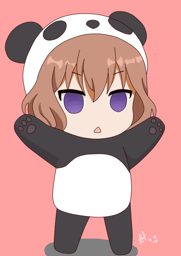

In [4]:
from fastdownload import download_url
dest = 'cartoon.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for 'real animals'


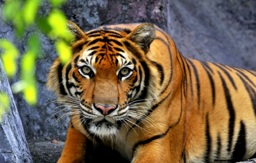

In [5]:
download_url(search_images('real animals', max_images=1)[0], 'real.jpg', show_progress=False)
Image.open('real.jpg').to_thumb(256, 256)


## Dataset

Lets create our dataset now as we are getting images as expected.

In [6]:
def download_images_to_folders(term: str, count: int):
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    sleep(10)
    urls = search_images(f'{term} animal photo', max_images=count)
    urls = [url for url in urls if not url.endswith('.gif')]
    download_images(dest, urls=urls)
    resize_images(path/term, max_size=400, dest=path/term)

In [7]:
from time import sleep
searches = 'animated', 'real'

path=Path('animated_or_not')
for term in searches:
    download_images_to_folders(term, 100)
    

Searching for 'animated animal photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'real animal photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
def count_images(path: str) -> int:
    folder = Path(path)
    count = 0
    for entry in folder.iterdir():
        if entry.is_file():
            count += 1
    return count

print(count_images('animated_or_not/animated'))
print(count_images('animated_or_not/real'))

62
98


Hmm.. lot of files got rejected because of gif

In [9]:
download_images_to_folders('animated', 50)

Searching for 'animated animal photo'


In [10]:
print(count_images('animated_or_not/animated'))
print(count_images('animated_or_not/real'))

97
98


Pretty balanced!

Let's verify that images are ok

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

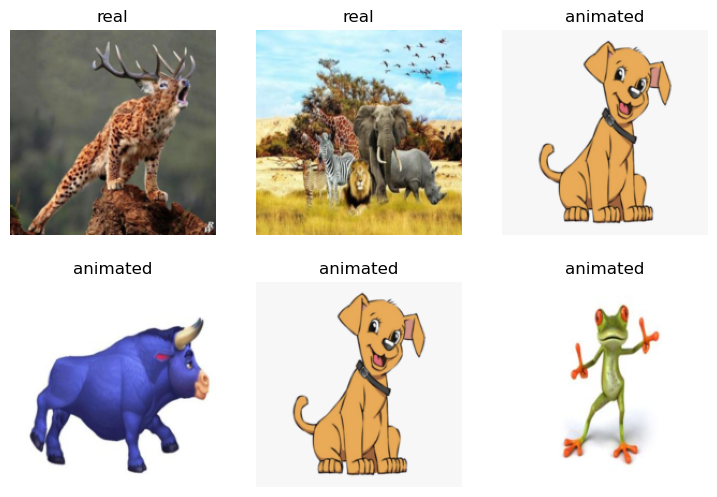

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

This makes sense!! Time to train the model.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.177054,1.176352,0.405405,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.422319,0.473940,0.216216,00:13
1,0.259262,0.199676,0.108108,00:13
2,0.170660,0.172939,0.081081,00:13
3,0.137808,0.155707,0.081081,00:13
4,0.110068,0.143292,0.054054,00:13


Let's test it on some images. Let's search some random cartoon animals.

Searching for 'disney pluto'


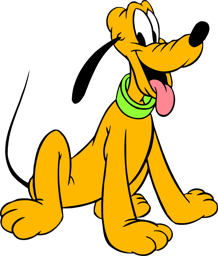

In [14]:
download_url(search_images('disney pluto', max_images=1)[0], 'pluto.jpg', show_progress=False)
Image.open('pluto.jpg').to_thumb(256, 256)

In [15]:
is_animated,_,probs = learn.predict(PILImage.create('pluto.jpg'))
print(f"This is: {is_animated}.")
print(f"Probability it's animated: {probs[0]:.4f}")

This is: animated.
Probability it's animated: 1.0000


Searching for 'pixar inside out'


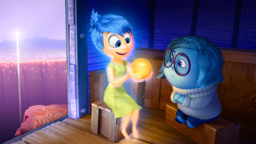

In [16]:
download_url(search_images('pixar inside out', max_images=1)[0], 'inside_out.jpg', show_progress=False)
Image.open('inside_out.jpg').to_thumb(256, 256)

In [17]:
is_animated,_,probs = learn.predict(PILImage.create('inside_out.jpg'))
print(f"This is: {is_animated}.")
print(f"Probability it's animated: {probs[0]:.4f}")

This is: animated.
Probability it's animated: 1.0000


Searching for 'cat'


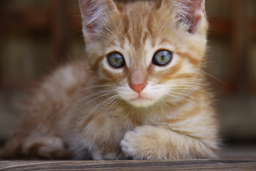

In [18]:
download_url(search_images('cat', max_images=1)[0], 'cat.jpg', show_progress=False)
Image.open('cat.jpg').to_thumb(256, 256)

In [19]:
is_animated,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is: {is_animated}.")
print(f"Probability it's animated: {probs[0]:.4f}")

This is: real.
Probability it's animated: 0.3609


Searching for 'happy_human'


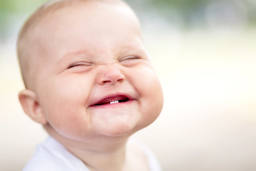

In [20]:
download_url(search_images('happy_human', max_images=1)[0], 'happy_human.jpg', show_progress=False)
Image.open('happy_human.jpg').to_thumb(256, 256)

In [21]:
is_animated,_,probs = learn.predict(PILImage.create('happy_human.jpg'))
print(f"This is: {is_animated}.")
print(f"Probability it's animated: {probs[0]:.4f}")

This is: real.
Probability it's animated: 0.0622
